In [2]:
import os
import sys
import faiss
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(os.path.abspath(".."))

from common.dataset.domain import fashion
from common.dataset.config import DatasetPath
from common.dataset.item_generator import generate_items
from common.dataset.user_generator import generate_users

# Dataset Path

In [3]:
current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath("data/dataset")

paths = DatasetPath(base_dir=dataset_dir, dataset_name="fashion")
print(paths.base_path)

/Users/hwangyungwan/Library/Mobile Documents/com~apple~CloudDocs/Documents/workspace/lecture/recsys/data/dataset/fashion


# User Metadata

In [3]:
# 중앙값 근처로 많이 생성되는 삼각분포(기본)
df_user = generate_users(
    num_users=10000,
    age_range=(18, 60),
    genders=("M", "F"),
    gender_probs=(0.5, 0.5),
    seed=42,
)

# ---------- 피크 나이를 30세로 명시 ---------- #
# df_user_30peak = generate_users(
#     num_users=10000, age_range=(18, 70), age_mode=30, seed=42
# )

# ---------- 기존 균등분포로 생성하고 싶다면 ---------- #
# df_user_uniform = generate_users(
#     num_users=10000, age_range=(18, 70), age_distribution="uniform", seed=42
# )

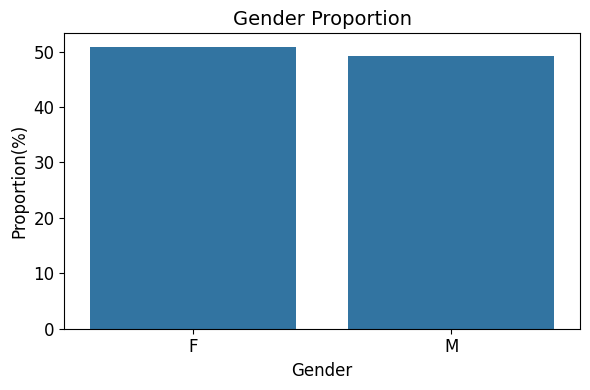

In [4]:
df_age_agg = df_user["gender"].value_counts(normalize=True).sort_index().reset_index()
df_age_agg["proportion"] = df_age_agg["proportion"] * 100

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(data=df_age_agg, x="gender", y="proportion")
plt.title("Gender Proportion", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Proportion(%)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

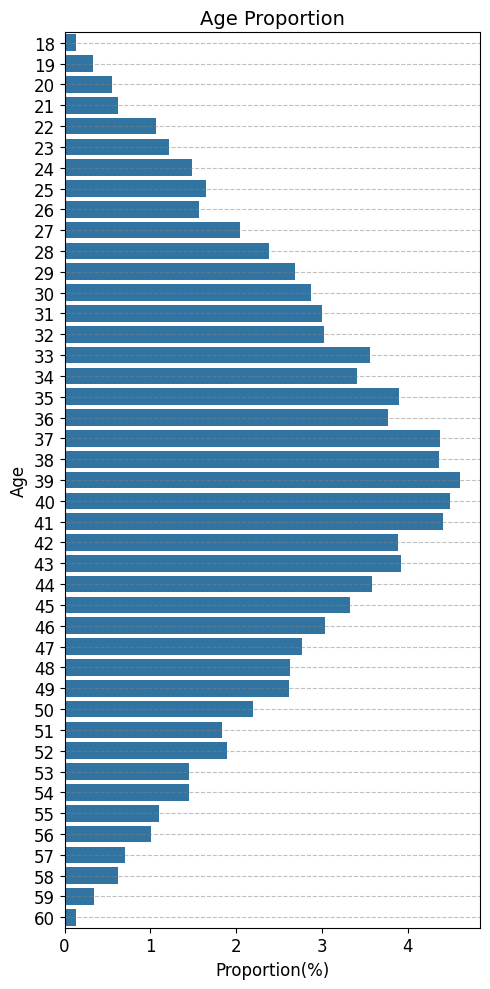

In [5]:
df_age_agg = df_user["age"].value_counts(normalize=True).sort_index().reset_index()
df_age_agg["age"] = df_age_agg["age"].astype(str)
df_age_agg["proportion"] = df_age_agg["proportion"] * 100

plt.figure(figsize=(5, 10), dpi=100)
sns.barplot(data=df_age_agg, x="proportion", y="age")
plt.title("Age Proportion", fontsize=14)
plt.xlabel("Proportion(%)", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis="y", linestyle="--", color="grey", alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
df_user.to_parquet(paths.user_metadata_path)

# Item Metadata

In [7]:
df_item = generate_items(fashion.Fashion, num_items=10000)
df_item.head()

,item_id,title,color,style,fit,material,season,sleeve,category
0,1,필수템! 스트리트 무드의 겨울용 레깅스,그레이,스트리트,세미오버핏,모달,겨울,숏,레깅스
1,2,봄 한정 린넨 소재 올리브 카디건,올리브,포멀,레귤러핏,린넨,봄,7부,카디건
2,3,레귤러핏 실루엣의 모달 오버롤,네이비,스포티,레귤러핏,모달,가을,숏,오버롤
3,4,"겨울 시즌, 빈티지 무드의 레드 린넨 롱슬리브 루즈핏 베스트",레드,빈티지,루즈핏,린넨,겨울,롱슬리브,베스트
4,5,"여름 시즌, 댄디 무드의 라벤더 코튼 숏슬리브 오버핏 트레이닝세트",라벤더,댄디,오버핏,코튼,여름,숏슬리브,트레이닝세트


In [8]:
from dataclasses import fields

columns = [f.name for f in fields(fashion.Fashion) if f.name != "name_templates"]

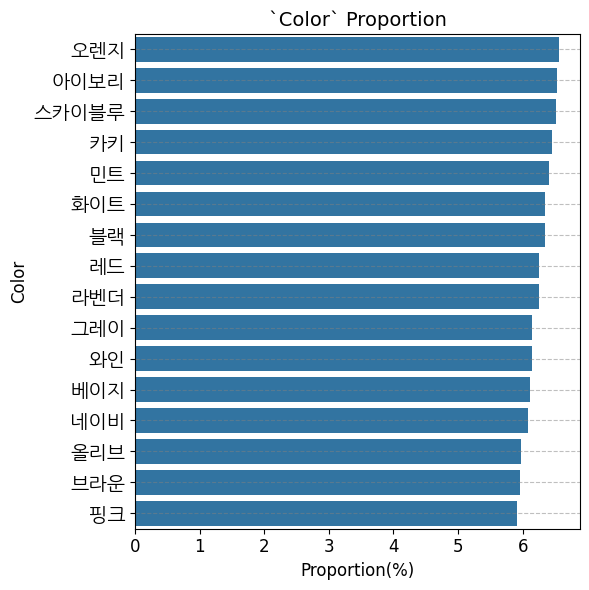

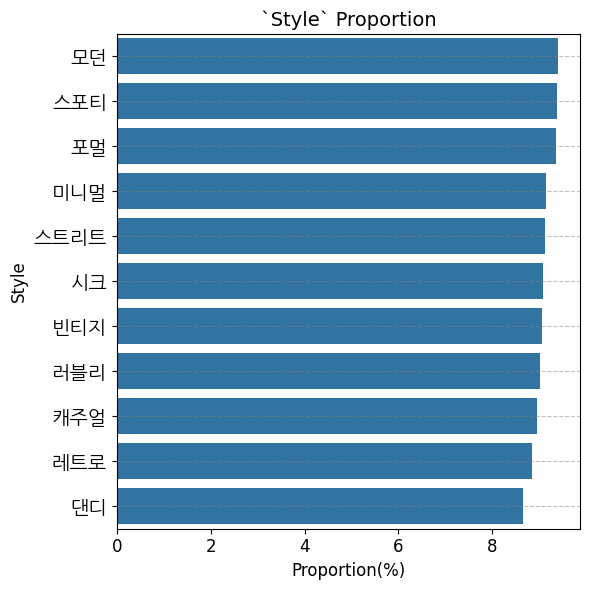

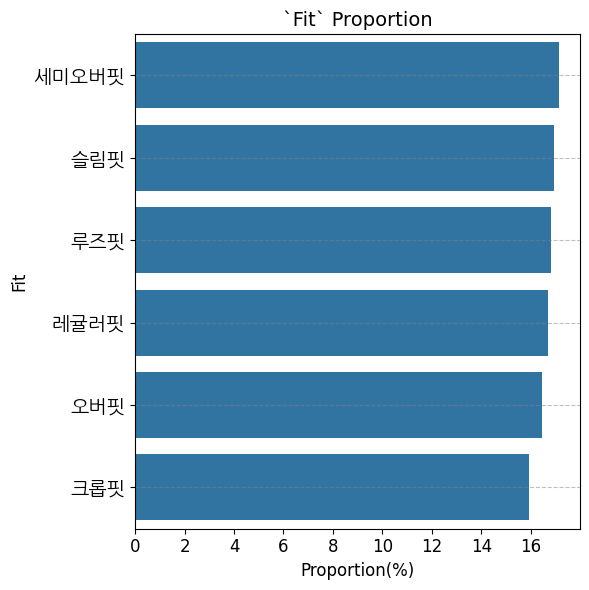

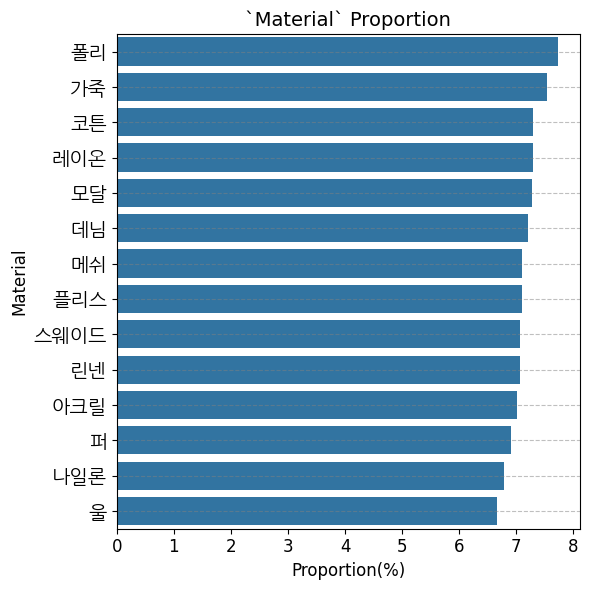

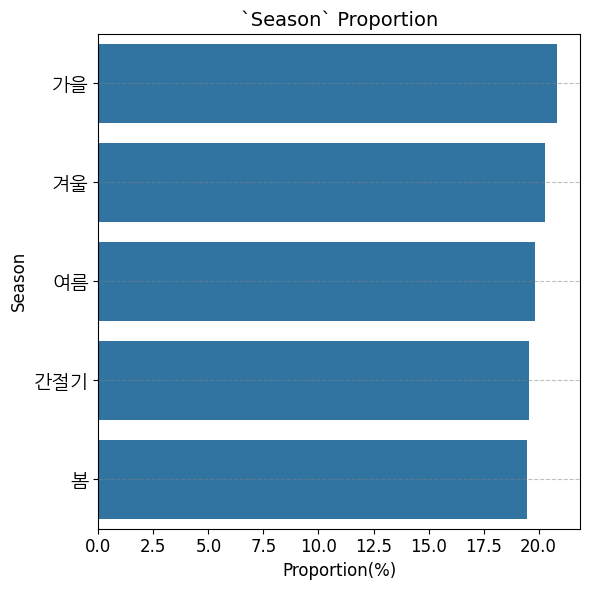

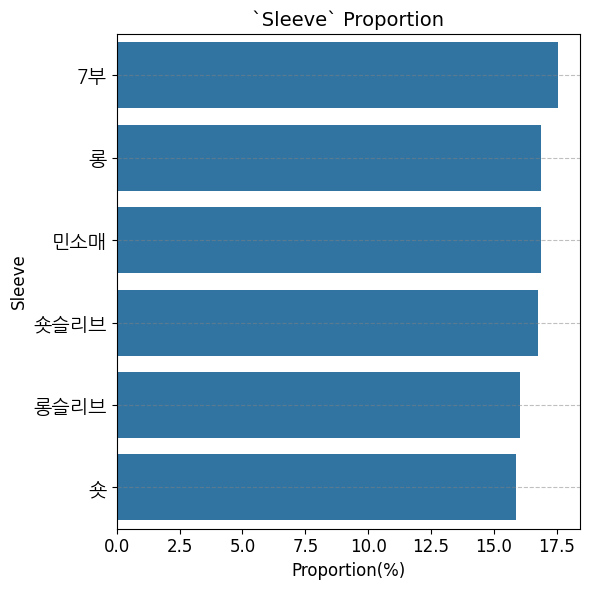

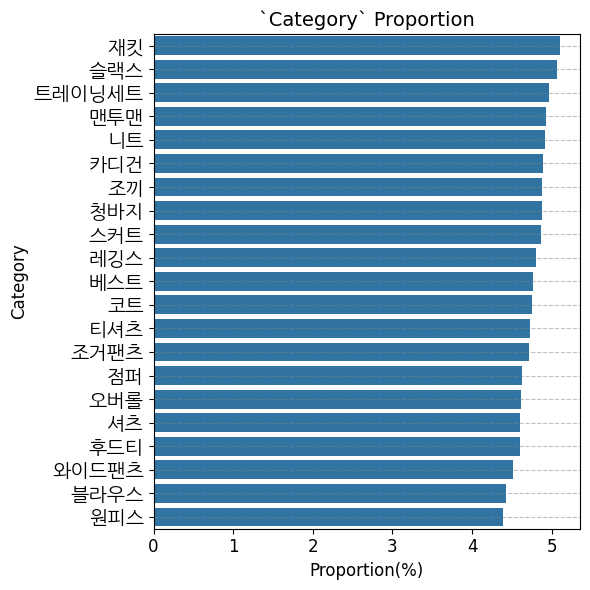

In [9]:
from matplotlib import font_manager

root_dir = "/".join(os.getcwd().split("/")[:-1])
font_path = font_path = Path(root_dir).joinpath("data/NanumGothic-Regular.ttf")
font_name = font_manager.FontProperties(fname=font_path).get_name()
fontprop = font_manager.FontProperties(fname=font_path, size=14)

for col in columns:
    df_item[col].value_counts()
    df_agg = (
        df_item[col]
        .value_counts(normalize=True)
        .sort_values(ascending=False)
        .reset_index()
    )
    df_agg[col] = df_agg[col].astype(str)
    df_agg["proportion"] = df_agg["proportion"] * 100

    plt.figure(figsize=(6, 6), dpi=100)
    sns.barplot(data=df_agg, x="proportion", y=col)
    plt.title(f"`{col.capitalize()}` Proportion", fontsize=14)
    plt.xlabel("Proportion(%)", fontsize=12)
    plt.ylabel(col.capitalize(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, fontproperties=fontprop)
    plt.grid(True, axis="y", linestyle="--", color="grey", alpha=0.5)
    plt.tight_layout()
    plt.show()

## Text Vector

### SentenceTransformer

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_item["title"].tolist(), normalize_embeddings=True)
embeddings = np.array(embeddings).astype("float32")
df_item["text_vector"] = embeddings.tolist()

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)


def find_similar_items(query_text: str, top_k: int = 5):
    query_vec = model.encode([query_text], normalize_embeddings=True).astype("float32")
    scores, indices = index.search(query_vec, top_k)

    print(f"\n[🔍 입력 상품명] {query_text}\n")
    print("[📌 유사한 상품]")
    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        print(f"{rank+1}. {df_item.iloc[idx]['title']} (score: {sim_score:.4f})")


find_similar_items("화이트 반팔 티셔츠")
find_similar_items("여름 린넨 원피스")

/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[🔍 입력 상품명] 화이트 반팔 티셔츠

[📌 유사한 상품]
1. 가을 루즈핏 화이트 코튼 롱 조거팬츠 (score: 0.8492)
2. 가을 오버핏 화이트 폴리 숏슬리브 레깅스 (score: 0.8488)
3. 가을 크롭핏 화이트 퍼 숏슬리브 트레이닝세트 (score: 0.8423)
4. 겨울 크롭핏 화이트 퍼 민소매 셔츠 (score: 0.8391)
5. 가을 오버핏 화이트 레이온 숏슬리브 점퍼 (score: 0.8387)

[🔍 입력 상품명] 여름 린넨 원피스

[📌 유사한 상품]
1. 여름 루즈핏 아이보리 울 숏슬리브 원피스 (score: 0.9306)
2. 여름에 어울리는 레드 원피스 (score: 0.9257)
3. 가을 감성 크롭핏 린넨 원피스 (score: 0.9256)
4. 여름에 어울리는 브라운 원피스 (score: 0.9242)
5. 여름 감성 크롭핏 데님 원피스 (score: 0.9240)


### e5-base

In [11]:
# 요약: 한국어 상품명 임베딩 품질을 높이기 위해 다국어 검색 특화 모델(E5)을 사용하고,
# 인덱스 문서엔 "passage: ", 질의엔 "query: " 프리픽스를 적용합니다.
from sentence_transformers import SentenceTransformer
import faiss

# 한국어 포함 멀티링궐 성능이 우수한 검색 특화 임베딩 모델
# 참고: intfloat/multilingual-e5-base (문서: "passage: ", 질의: "query: ")
model = SentenceTransformer("intfloat/multilingual-e5-base")

# E5 모델 가이드에 따라 passage 프리픽스를 붙여 인덱싱
corpus_texts = ["passage: " + t for t in df_item["title"].tolist()]
embeddings = model.encode(corpus_texts, normalize_embeddings=True)
embeddings = np.array(embeddings).astype("float32")
df_item["text_vector"] = embeddings.tolist()

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)


def find_similar_items(query_text: str, top_k: int = 5):
    # E5 모델 가이드에 따라 query 프리픽스를 사용
    query_vec = model.encode(
        ["query: " + query_text], normalize_embeddings=True
    ).astype("float32")
    scores, indices = index.search(query_vec, top_k)

    print(f"\n[🔍 입력 상품명] {query_text}\n")
    print("[📌 유사한 상품]")
    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        print(f"{rank + 1}. {df_item.iloc[idx]['title']} (score: {sim_score:.4f})")


find_similar_items("화이트 반팔 티셔츠")
find_similar_items("여름 린넬 원피스")


[🔍 입력 상품명] 화이트 반팔 티셔츠

[📌 유사한 상품]
1. 가을에 어울리는 화이트 티셔츠 (score: 0.8709)
2. 겨울에 어울리는 화이트 티셔츠 (score: 0.8674)
3. 화이트 컬러의 레트로 스타일 스웨이드 티셔츠 (score: 0.8662)
4. 가을에 어울리는 화이트 셔츠 (score: 0.8625)
5. 간절기에 어울리는 화이트 셔츠 (score: 0.8623)

[🔍 입력 상품명] 여름 린넬 원피스

[📌 유사한 상품]
1. 여름 시즌, 레트로 무드의 오렌지 린넨 롱 오버핏 원피스 (score: 0.8783)
2. 여름에 어울리는 레드 원피스 (score: 0.8724)
3. 여름 한정 레이온 소재 레드 원피스 (score: 0.8683)
4. 여름에 어울리는 오렌지 원피스 (score: 0.8680)
5. 여름 한정 린넨 소재 민트 레깅스 (score: 0.8677)


## Image Vector

In [12]:
# 생략

## Save

In [13]:
df_item_vectors = df_item[["item_id", "text_vector"]]
df_item_vectors.to_parquet(paths.text_vectors_path)

df_item.drop(columns=["text_vector"]).to_parquet(paths.item_metadata_path)